In [2]:
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

Освежим в памяти основные этапы в торче. Потом разберемся с каждым по отдельности 

#### DataSets and DataLoaders

In [3]:
from torch.utils.data import Dataset
from torchvision import  datasets
from torchvision.transforms import ToTensor

по какой то странной причине вскод/джупитер дохнут, когда я пытаюсь подгрузить датасет, так что придется грузить из отдельного скрипта

In [5]:
torch.cuda.is_available()

True

In [11]:
trainingData = datasets.FashionMNIST(
    root = "./data",
    train = True,
    download=False,
    transform = ToTensor()
)
testData = datasets.FashionMNIST(
    root = "./data",
    train = False,
    download=False,
    transform = ToTensor()
)

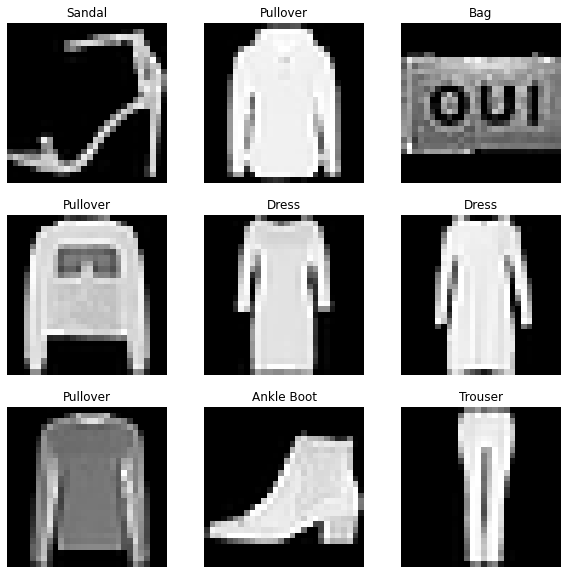

In [12]:
labels= {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
f = plt.figure(figsize = (10,10))
cols, rows = 3,3
for i in range(1,cols*rows + 1):
    idx = torch.randint(len(trainingData),size=(1,)).item()
    img, label = trainingData[idx]
    f.add_subplot(rows, cols, i)
    plt.title(labels[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

Класс Датасет это некоторая абстракция над файловой системой, чья задача загружать примеры в память. Очевидно, что можно писать кастомные загрузчики.  
Для этого делаем новый класс и наследуемся от `Dataset`. Контракт следущий:
1. \_\_init\_\_(*args) -> None -  объяснять, что такое инит не стоит. Главное помнить, что помимо очевидного в него лучше засунуть трансформы 
2. \_\_len\_\_() -> Integer - должен вернуть количество образцов
3. \_\_getitem\_\_(Integer) -> Object - принимает индекс и возвращает соответствующий объект 

поскольку датасет дает нам один сэмпл за раз, а нейронкам мы все кормим минибатчами, нам нужен еще один слой между ними. В нашем случае это DataLoader

In [13]:
from torch.utils.data import DataLoader
trainDL = DataLoader(trainingData,batch_size=64,shuffle=True)
testDL = DataLoader(testData,batch_size=64,shuffle=True)

Теперь можем итерироваться 

images,  torch.Size([64, 1, 28, 28])
labels,  torch.Size([64])


Text(0.5, 1.0, 'Sneaker')

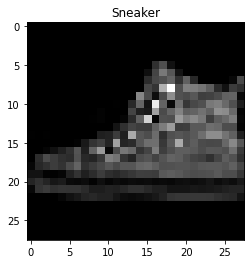

In [20]:
trainImgs, trainLabels = next(iter(trainDL))
print("images, ", trainImgs.size())
print("labels, ", trainLabels.size())
plt.imshow(trainImgs[0].squeeze(), cmap="gray")
plt.title(labels[trainLabels[0].item()])

#### AutoGrad

Попробуем просимулировать простейшую сетку с одним слоем

In [25]:
x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5,3,requires_grad=True)
b = torch.randn(3, requires_grad=True)
out = x @ w + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(out, y)

все эти операции выстраиваются в граф вычислений

x -> * -> + -> out -> CE -> loss  
        |       |  
        w     b  
w и b это оптимизируемые параметры, так что мы хотим вычислить градиент фунции потерь  
(кросс энтропии) относительно этих параметров

Функции, которые применяются к тензорам, это объекты типа Function. Этот объект  
знает, как вычислять прямой ход и производную, во время обратного распространения.  
Ссылка на функцию обратного распространения хранится в в атрибуте grad_fn  

In [26]:
print(f"Gradient function for z = {out.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x00000232C2B3EA60>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x00000232C23366D0>


теперь можно вычислить градиенты

In [27]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2429, 0.3128, 0.1796],
        [0.2429, 0.3128, 0.1796],
        [0.2429, 0.3128, 0.1796],
        [0.2429, 0.3128, 0.1796],
        [0.2429, 0.3128, 0.1796]])
tensor([0.2429, 0.3128, 0.1796])


очевидно, что .grad можно звать только для тензоров, которые были помечены как requires_grad  
backward можно звать только один раз. Если хочется больше, в параметрах кормим retain_graph=True   

Градиент трекинг можно выключать. Нужно из соображений производительности или с целью  
заморозки параметров при файнтюнинге 

In [28]:
out1 = x @ w + b 
print(out1.requires_grad)
with torch.no_grad():
    out1 = x @ w + b 
print(out1.requires_grad)


True
False
